In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured:", gpus)
    except RuntimeError as e:
        print("RuntimeError:", e)
else:
    print("No GPU detected by TensorFlow")


GPU is available and configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from data_loading import OxfordPetDataset
from augmentation import random_flip, augmentation_layers_geometric, augmentation_layers_color
from models import UNet_model #2.a, 2.b exercises
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (128, 128)
dataset.res_norm(reshape_size)

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669




In [4]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    print(data)
    return data['image'], data['image']

# Apply to all datasets
train1 = train.map(extract_image_mask)
val1 = val.map(extract_image_mask)
test1 = test.map(extract_image_mask)



{'image': <tf.Tensor 'args_0:0' shape=(128, 128, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(128, 128, 1) dtype=uint8>}
{'image': <tf.Tensor 'args_0:0' shape=(128, 128, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(128, 128, 1) dtype=uint8>}
{'image': <tf.Tensor 'args_0:0' shape=(128, 128, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(128, 128, 1) dtype=uint8>}


Autoencoder Implementation & Training

In [5]:
BATCH_SIZE = 16

# Batch the data and use prefetching to optimize loading speed
train_ds = train1.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val1.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test1.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
from models import Autoencoder
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

# Create top-level folder and subdirectories if they don't exist
top_dir = "task_2b/baseline"
results_dir = os.path.join(top_dir, "autoencoder_training_results")
models_dir = os.path.join(top_dir, "autoencoder_models")
weights_dir = os.path.join(top_dir, "autoencoder_weights")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

# Define folder for saving the best autoencoder model
best_model_folder = os.path.join(top_dir, "autoencoder_best_baseline_model")

# Initialize and compile autoencoder
autoencoder = Autoencoder(input_shape=(128, 128, 3))
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Define Early Stopping (restores best weights)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

# Define ModelCheckpoint to save the best model into the specified folder
checkpoint = ModelCheckpoint(
    best_model_folder,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model with early stopping & 100 epochs (adjust epochs as needed)
history = autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[checkpoint, early_stopping]
)



Epoch 1/100


Training history saved at: task_2b/baseline\autoencoder_training_results\autoencoder_baseline_training.csv


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\autoencoder_baseline_training_tf\assets


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\autoencoder_baseline_training_tf\assets


Autoencoder model saved at: task_2b/baseline\autoencoder_models\autoencoder_baseline_training_tf
Autoencoder weights saved at: task_2b/baseline\autoencoder_weights\autoencoder_baseline_weights.h5


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\encoder_baseline_training_tf\assets


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\encoder_baseline_training_tf\assets


Encoder model saved at: task_2b/baseline\autoencoder_models\encoder_baseline_training_tf
Encoder weights saved at: task_2b/baseline\autoencoder_weights\encoder_baseline_weights.h5


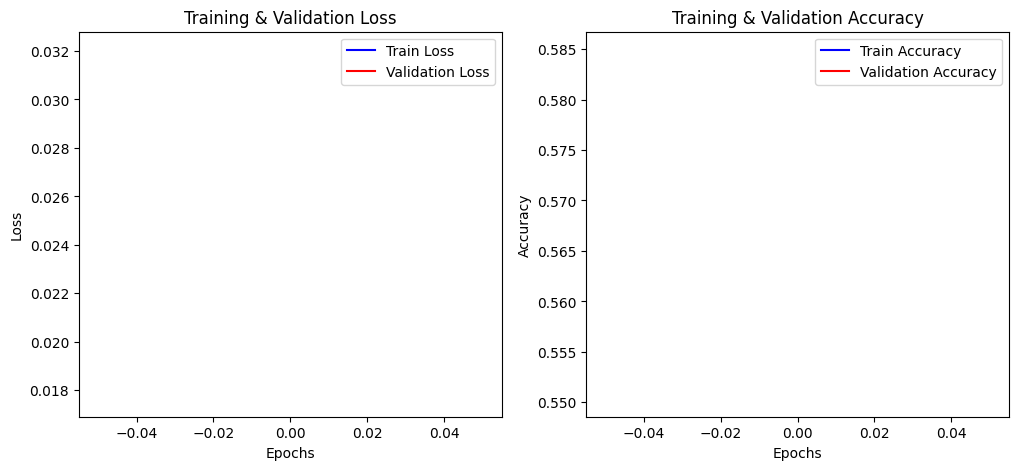

In [7]:

# Load the best model from the folder
best_autoencoder = tf.keras.models.load_model(best_model_folder)

# Save training history to CSV in the results folder
history_df = pd.DataFrame(history.history)
csv_path = os.path.join(results_dir, "autoencoder_baseline_training.csv")
history_df.to_csv(csv_path, index=False)
print(f"Training history saved at: {csv_path}")

# Save the final autoencoder model (from the best model) in TensorFlow format
autoencoder_model_path = os.path.join(models_dir, "autoencoder_baseline_training_tf")
best_autoencoder.save(autoencoder_model_path, save_format="tf")
print(f"Autoencoder model saved at: {autoencoder_model_path}")

# Save only the autoencoder weights
autoencoder_weights_path = os.path.join(weights_dir, "autoencoder_baseline_weights.h5")
best_autoencoder.save_weights(autoencoder_weights_path)
print(f"Autoencoder weights saved at: {autoencoder_weights_path}")

# Extract and save the encoder part of the autoencoder
encoder = best_autoencoder.encoder
encoder_model_path = os.path.join(models_dir, "encoder_baseline_training_tf")
encoder.save(encoder_model_path, save_format="tf")
print(f"Encoder model saved at: {encoder_model_path}")

# Save only the encoder weights
encoder_weights_path = os.path.join(weights_dir, "encoder_baseline_weights.h5")
encoder.save_weights(encoder_weights_path)
print(f"Encoder weights saved at: {encoder_weights_path}")

# Plot Training & Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss', color='blue')
plt.plot(history_df['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")

plt.show()

Autoencoder Model Weights Loaded Successfully from task_2b/baseline\autoencoder_weights\autoencoder_baseline_weights.h5
1/1 [==============================] - 1s 1s/step


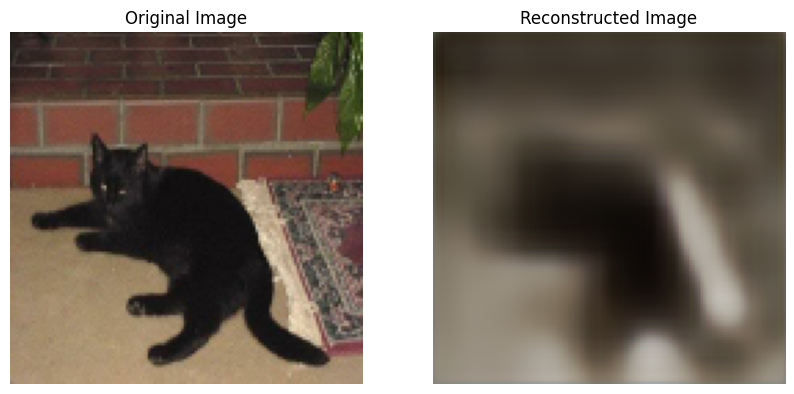

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from models import Autoencoder

# Define folder paths for weights
top_dir = "task_2b/baseline"

# Define subdirectories
weights_dir = os.path.join(top_dir, "autoencoder_weights")


autoencoder_weights_path = os.path.join(weights_dir, "autoencoder_baseline_weights.h5")

# Rebuild the autoencoder model
autoencoder = Autoencoder(input_shape=(128, 128, 3))

# Build the model by calling it with a dummy input
dummy_input = tf.random.normal((1, 128, 128, 3))  # Batch size of 1
autoencoder(dummy_input)  # Ensures layers are built

# Load the saved weights
if os.path.exists(autoencoder_weights_path):
    autoencoder.load_weights(autoencoder_weights_path)
    print(f"Autoencoder Model Weights Loaded Successfully from {autoencoder_weights_path}")
else:
    raise FileNotFoundError(f"Error: Weights file not found at {autoencoder_weights_path}")

# Fetch a batch from the test dataset
test_batch = next(iter(test_ds))  # Get one batch (batch_size, 256, 256, 3)
test_images = test_batch[0].numpy()  # Convert to NumPy array

# Select a random image
random_idx = random.randint(0, test_images.shape[0] - 1)
test_img = np.expand_dims(test_images[random_idx], axis=0)  # Add batch dimension

# Predict (Reconstruct) the image
pred = autoencoder.predict(test_img)

# Display Original & Reconstructed Image
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(test_img[0])  # Remove batch dimension
plt.title('Original Image')
plt.axis("off")

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(pred[0])  # Remove batch dimension
plt.title('Reconstructed Image')
plt.axis("off")

plt.show()


In [9]:
import tensorflow as tf
import pandas as pd
import os
from models import Autoencoder

# Define folder paths
top_dir = "task_2b/baseline"

# Define subdirectories
weights_dir = os.path.join(top_dir, "autoencoder_weights")
results_dir = os.path.join(top_dir,"autoencoder_training_results")


# Ensure results directory exists
os.makedirs(results_dir, exist_ok=True)

# Define paths for saved weights
autoencoder_weights_path = os.path.join(weights_dir, "autoencoder_baseline_weights.h5")

# Rebuild the autoencoder model
autoencoder = Autoencoder(input_shape=(128, 128, 3))

# Build the model by calling it with a dummy input
dummy_input = tf.random.normal((1, 128, 128, 3))  # Batch size of 1
autoencoder(dummy_input)  # Ensures layers are built

# Load the saved weights
if os.path.exists(autoencoder_weights_path):
    autoencoder.load_weights(autoencoder_weights_path)
    print(f"Autoencoder Model Weights Loaded Successfully from {autoencoder_weights_path}")
else:
    raise FileNotFoundError(f"Error: Weights file not found at {autoencoder_weights_path}")

# Evaluate the model on the test dataset
autoencoder.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
test_loss, test_accuracy = autoencoder.evaluate(test_ds)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save test results to CSV
test_results = pd.DataFrame({
    "Metric": ["Test Loss", "Test Accuracy"],
    "Value": [test_loss, test_accuracy]
})
csv_path = os.path.join(results_dir, "autoencoder_baseline_test_results.csv")
test_results.to_csv(csv_path, index=False)
print(f"Test results saved at: {csv_path}")


Autoencoder Model Weights Loaded Successfully from task_2b/baseline\autoencoder_weights\autoencoder_baseline_weights.h5
230/230 [==============================] - 7s 21ms/step - loss: 0.0189 - accuracy: 0.5794
Test Loss: 0.0189
Test Accuracy: 0.5794
Test results saved at: task_2b/baseline\autoencoder_training_results\autoencoder_baseline_test_results.csv


In [10]:
def process_image_mask(data):
    """Extract image and mask from dictionary"""
    return data['image'], data['segmentation_mask']

# Apply to all datasets
train = train.map(process_image_mask)
val = val.map(process_image_mask)
test = test.map(process_image_mask)

BATCH_SIZE = 16
EPOCHS = 100

# Batch the data and use prefetching to optimize loading speed
train_ds = train.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [11]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from models import build_segmentation_decoder

# Paths where your encoder is saved
top_dir = "task_2b/baseline"

models_dir = os.path.join(top_dir, "autoencoder_models")
weights_dir = os.path.join(top_dir,"autoencoder_weights")


encoder_model_path = os.path.join(models_dir, "encoder_baseline_training_tf")
encoder_weights_path = os.path.join(weights_dir, "encoder_baseline_weights.h5")

# Load the Pretrained Encoder
encoder = tf.keras.models.load_model(encoder_model_path)
encoder.load_weights(encoder_weights_path)
print("✅ Pretrained encoder loaded successfully!")

# Build U-Net with pretrained encoder
model = build_segmentation_decoder(encoder, num_classes=3)

### **🔹 Compile Model for Multi-Class Segmentation**
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



✅ Pretrained encoder loaded successfully!


In [12]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from metrics import MeanIoUWrapper, dice_coefficient
from models import build_segmentation_decoder  

# Define top-level directory
top_dir = "task_2b/baseline"

# Instantiate the metric once
miou_metric = MeanIoUWrapper(num_classes=3)

# Directories for the pretrained encoder (assumed to be already saved)
encoder_models_dir = os.path.join(top_dir, "autoencoder_models")  
encoder_weights_dir = os.path.join(top_dir, "autoencoder_weights")

# Directory for saving the best segmentation model
segmentation_model_dir = os.path.join(top_dir, "segmentation_pretrained_model")
os.makedirs(segmentation_model_dir, exist_ok=True)

# Directory for saving training results CSV
results_dir = os.path.join(top_dir, "segmentation_training_results")
os.makedirs(results_dir, exist_ok=True)

# Define the folder path for the best segmentation model (SavedModel format)
best_model_folder = os.path.join(segmentation_model_dir, "segmentation_model_with_pretrained_encoder")

# Load Pretrained Encoder
encoder_model_path = os.path.join(encoder_models_dir, "encoder_baseline_training_tf")
encoder_weights_path = os.path.join(encoder_weights_dir, "encoder_baseline_weights.h5")
encoder = tf.keras.models.load_model(encoder_model_path)
encoder.load_weights(encoder_weights_path)
print("Pretrained encoder loaded successfully!")

# Build Segmentation Model with Pretrained Encoder
segmentation_model = build_segmentation_decoder(encoder, num_classes=3)


segmentation_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', miou_metric, dice_coefficient]
)

# Define callbacks: Using SavedModel format to avoid HDF5 conflicts.
checkpoint = ModelCheckpoint(
    best_model_folder,  # This is a folder, not a file
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_format='tf'  # Save as TensorFlow SavedModel
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the segmentation model (adjust epochs as needed)
history = segmentation_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)

Pretrained encoder loaded successfully!
Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.6988 - mean_iou: 0.3714 - dice_coefficient: 0.6988   
Epoch 1: val_loss improved from inf to 0.65428, saving model to task_2b/baseline\segmentation_pretrained_model\segmentation_model_with_pretrained_encoder


KeyboardInterrupt: 

230/230 [==============================] - 6s 20ms/step - loss: 0.5807 - accuracy: 0.7706 - iou_metric: 0.9675 - dice_coefficient: 0.7706

Best Segmentation Model Test Metrics:
Loss: 0.5807, Accuracy: 0.7706
IoU: 0.9675, Dice Coefficient: 0.7706
Training history saved at: task_2b/baseline\segmentation_training_results\segmentation_baseline_training.csv


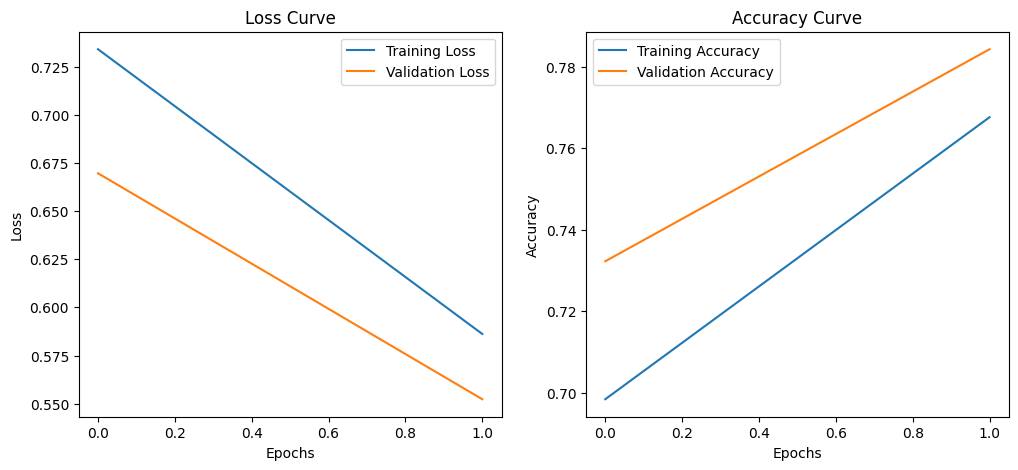

Model training complete! Best segmentation model is saved at task_2b/baseline\segmentation_pretrained_model\segmentation_model_with_pretrained_encoder


In [18]:
# Load the best segmentation model from the SavedModel folder
best_segmentation_model = tf.keras.models.load_model(
    best_model_folder,
    custom_objects={'iou_metric': iou_metric, 'dice_coefficient': dice_coefficient}
)

# Evaluate the best segmentation model on the test dataset
test_loss, test_accuracy, test_iou, test_dice = best_segmentation_model.evaluate(test_ds)
print("\nBest Segmentation Model Test Metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
print(f"IoU: {test_iou:.4f}, Dice Coefficient: {test_dice:.4f}")

# Save the training history as a CSV file in the segmentation_training_results folder
csv_path = os.path.join(results_dir, "segmentation_baseline_training.csv")
history_df = pd.DataFrame(history.history)
history_df.to_csv(csv_path, index=False)
print(f"Training history saved at: {csv_path}")

# Function to plot training progress
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss Curve')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Accuracy Curve')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.show()

# Plot the training history
plot_training_history(history)

print(f"Model training complete! Best segmentation model is saved at {best_model_folder}")